## Conteúdo
 1. [Introdução](#1.-Introdução)
 2. [Problema](#2.-Problema)<br>
 2.1 [Carga e visão global dos dados](#2.1-Carga-e-vis%C3%A3o-global-dos-dados)<br>
 2.2 [Análise estatística](#2.2-An%C3%A1lise-estat%C3%ADstica)<br>
 2.3 [Preparação dos dados](#2.3-Prepara%C3%A7%C3%A3o-dos-dados)<br>
 2.4 [Exploração dos dados](#2.4-Explora%C3%A7%C3%A3o-dos-dados)<br>
 &nbsp;&nbsp;2.4.1 [Visualização da série temporal](#2.4.1-Visualiza%C3%A7%C3%A3o-da-s%C3%A9rie-temporal)<br>
 &nbsp;&nbsp;2.4.2 [Decomposição em erro, tendência e sazonalidade](#2.4.2.-Decomposi%C3%A7%C3%A3o-em-erro,-tend%C3%AAncia-e-sazonalidade)<br>
 &nbsp;&nbsp;2.4.3 [Distribuição geral das vendas](#2.4.3-Distribui%C3%A7%C3%A3o-geral-das-vendas)<br>
 2.5 [Divisão de treino e teste](#2.5-Divis%C3%A3o-de-treino-e-teste)<br>
 3. [Exponential Smoothing simples](#3.-Exponential-Smoothing-simples)
 4. [Exponential Smoothing duplo](#4.-Exponential-Smoothing-duplo)
 5. [Exponential Smoothing triplo (Holt-Winters)](#5.-Exponential-Smoothing-triplo-(Holt-Winters))
 6. [Conclusão](#6.-Conclusão)
 7. [Referências](#7.-Referências)
***

## 1. Introdução

Desde o início desse ano, a Pesquisa Aplicada da Senior vêm trabalhando em parceria com a Gestão de Supermercados para realizar a análise e previsão de séries temporais. [No primeiro post](http://velox.interno.senior.com.br/wordpress/research/2019/09/09/previsao-de-demanda/) foi abordado a importância para o negócio de antecipar a previsão de demanda de forma acertiva. Entretando, as séries temporais podem ter diversas características que dificultem esse trabalho. Para isso, [o segundo post](http://velox.interno.senior.com.br/wordpress/research/2019/10/14/previsao-de-demanda-analise-de-series-temporais/) mostra algumas técnicas utilizadas para realizar a análise das séries temporais.

Em relação a previsão, na literatura há várias formas para relizar a previsão, que vão desde métodos estatísticos até técnicas modernas como redes neurais. Esse post irá abordar um dos métodos utilizados para prever valores futuros de um conjunto da dados ordenados por uma grandeza de tempo. Esse método é chamado de Exponential Smoothing e será descrito e demonstrado em detalhes nesse notebook [[1](#ref-1)].

***

## 2. Problema

Para exemplificar o funcionamento do Exponential Smoothing, uma série temporal será utilizada contendo os dados reais de vendas de um determinado produto. Antes de entrar no método de previsão é necessário realizar uma análise para entender melhor o comportamento da série temporal.

### 2.1 Carga e visão global dos dados

O primeiro passo é carregar as bibliotecas que serão utilizadas durante o desenvolvimento desse post

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import median_absolute_deviation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
%matplotlib inline
sns.set(style='white', palette='muted', color_codes=True)

Na sequência, os dados são carregados para um objeto dataframe da biblioteca Pandas. Além disso, a coluna `timestreamp` é convertida de string para data. Finalmente, a terceira linha executa o comando mostrar um prévia do dataset.

In [2]:
df = pd.read_csv('ts.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,sales
0,2016-01-01,47
1,2016-01-02,23
2,2016-01-03,16
3,2016-01-04,6
4,2016-01-05,11


O dataset possui apenas duas colunas:
 - `timestamp`: A data de ocorrencia das vendas;
 - `sales`: A quantidade vendida.

### 2.2 Análise estatística

É possível descrever algumas estatísticas dos dados:

In [3]:
df['sales'].describe()

count    1127.000000
mean       13.889086
std        17.522711
min         0.000000
25%         3.000000
50%         8.000000
75%        18.000000
max       161.000000
Name: sales, dtype: float64

Através do resumo das estatísticas descritivas, pode-se observar algumas características dos dados:
 - O intervalo de vendas varia de 0 até 161;
 - A média de vendas é de aproximadamente 14;
 - A mediana é de 8 unidades vendidas;
 - O desvio padrão é de aproximadamente 17.5;
 
O desvio padrão é uma métrica que descreve a variação da série temporal. Porém, pode-se observar picos de vendas na época de festas de final do ano. Esse valores atípicos são tratados como *outliers*. Para que o desvio padrão não seja afetado pelos *outliers*, utiliza-se o desvio mediano absoluto da mediada (MAD). O valor da MAD é obtido através do calculo da mediana da diferença das observações e da mediana. Seja $m$ o valor da mediana da série temporal e $X$ o vetor de vendas com tamanho $n$, a MAD é calcilada pela seguinte fórmula:

$$MAD = median(|X_1 - m|, |X_2 - m|, \dots, |X_n - m|)$$

In [4]:
median_absolute_deviation(df['sales'])

8.8956

### 2.3 Preparação dos dados

É necessário verificar se existem datas com valores zerados. Para isso usa-se a diferença entre o intervalo de datas e as datas que estão presentes no dataset

In [5]:
len(pd.date_range(df['timestamp'].min(), df['timestamp'].max()).difference(df['timestamp']))

294

Existem 294 datas que não estão presentes no dataset. Isso pode acontecer por diversos fatores como problema na origem dos dados, o produto não vendeu por falta de estoque, feriados, etc. Nesse tipo de situação o ideal é investigar para tentar entender os motivos da datas que não estão preenchidas, e preencher essas datas. Existem várias formas de preenchimento dos dados (como demonstrado no [post anterior](http://velox.interno.senior.com.br/wordpress/research/2019/10/14/previsao-de-demanda-analise-de-series-temporais/)) e a escolha do procedimento ideal pode variar de acordo com o motivo. Além disso, pode-se realizar a predição utilizando diferentes formas de preenchimento e escolher a que obteve melhores resultados no modelo de predição. 

Por se tratar de um post que tem por objetivo de explicar o método Exponential Smoothing, o último valor válido será propagado para frente. Para isso, o método `data_range` do Pandas cria um novo índice contendo todas as datas. Na linha 2, o dataframe é indexado pela coluna `timestamp` e reindexado pelo novo índice. Nas linha 3 e 4 os valores nulos de vendas são preechidos com o último valor válido e das datas com o valor do índice, respectivamente. Finalmente na linha 5 o índice é resetado.

In [6]:
idx = pd.date_range(df['timestamp'].min(), df['timestamp'].max(), freq='D')
df = df.set_index('timestamp').reindex(idx)
df['sales'] = df['sales'].ffill()
df['timestamp'] = df.index
df = df.reset_index(drop=True)
df.head()

,sales,timestamp
0,47.0,2016-01-01
1,23.0,2016-01-02
2,16.0,2016-01-03
3,6.0,2016-01-04
4,11.0,2016-01-05


### 2.4 Exploração dos dados

Um passo importante realizar uma análise dos dados de forma visual para tentar entender o comportamento da série temporal e seus componentes.

#### 2.4.1 Visualização da série temporal

Finalmente chegou a hora de visualizar a série temporal do total de vendas diárias em relação a data

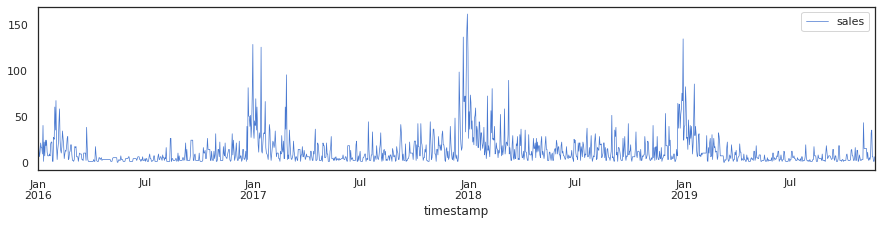

In [7]:
df.plot(x='timestamp', figsize=(15,3), lw=.7)

Através de uma análise visual pode-se observar que o produto tem um aumento das vendas na época de festas de final do ano. Em outras palavras, a série temporal possui uma sazonalidade onde o efeito ocorre a cada 365,25 dias. Além disso, parece possuir um sazonalidade menor, que pode ser semanal. A tendência da série temporal parece estável.

#### 2.4.2. Decomposição em erro, tendência e sazonalidade

A decomposição de uma série temporal separa os componentes de tendência, sazonalidade e erro. Para isso, pode-se utilizar a biblioteca statsmodels.

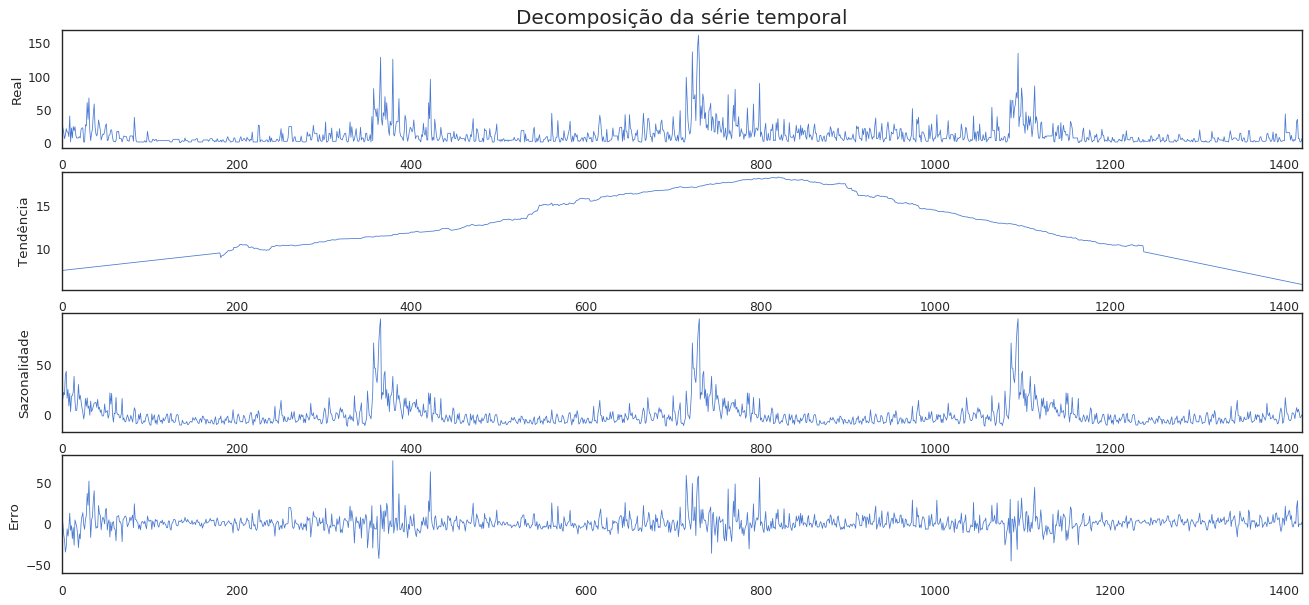

In [8]:
dec_add = seasonal_decompose(df['sales'], freq=365, extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(20,9), dpi=80)
ax[0].set_title('Decomposição da série temporal', fontsize=18)
dec_add.observed.plot(ax=ax[0], legend=False, linewidth=.7)
ax[0].set_ylabel('Real')
dec_add.trend.plot(ax=ax[1], legend=False, linewidth=.7)
ax[1].set_ylabel('Tendência')
dec_add.seasonal.plot(ax=ax[2], legend=False, linewidth=.7)
ax[2].set_ylabel('Sazonalidade')
dec_add.resid.plot(ax=ax[3], legend=False, linewidth=.7)
ax[3].set_ylabel('Erro')

plt.show()

O primeiro gráfico mostra os valores das vendas diárias. A tendência, mostrada no segundo gráfico, tem um subida lenta em um intervalo de aproximadamente 15 unidade. Na sequência a tendência tem um decréscimo. Pela análise visual é perceptível a sazonalidade na época de festas de final de ano. A decomposição mostra o comportamento da sazonalidade. Finalmente, o último gráfico mostra o erro. O erro é o comportamento que não é explicado nem pela tendência e nem pela sazonalidade.

#### 2.4.3 Distribuição geral das vendas

De acordo com as estatísticas obtidas em 2.2, a média é muito maior que a mediana, por isso a distribuição é assimétrica positiva, onde a "cauda" da distribuição tende para o lado direito.

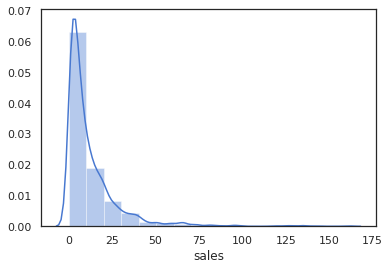

In [9]:
sns.distplot(df['sales'], bins=16);

Esse tipo de distribuição tem um efeito negativo em vários modelos de previsão, especialmente os modelos de regressão. No exponential smoothing, esse efeito deve ser sentido no modelo simples e no duplo. A distribuição ideal seria uma normal, ou próxima disso. Nesse caso, é necessário uma transformação para obter uma distribuição normal dos valores. Uma transformação bastante utilizada é o logarítmo dos valores. Como esse trabalho tem o objetivo de demonstrar o Exponential Smoothing, a transformação não será aplicada.

### 2.5 Divisão de treino e teste

Antes de aplicar o modelo é necessário dividir o dataset em treino e teste. Em séries temporais não se deve realizar a divisão de forma aleatória. Isso porque o dataset possui um variável que ordena os dados e que precisa ser repeitada. Portanto, os últimos 45 dias de vendas serão reservados para o teste e o restante para treino.

In [10]:
forecast_horizon = 45
split_date = df['timestamp'].max() + datetime.timedelta(days=-forecast_horizon+1)
train, test = df.iloc[:-forecast_horizon], df.iloc[-forecast_horizon:]
print(f'Tamanho do dataset:    {len(df):>4}')
print(f'Reservado para treino: {len(train):>4}')
print(f'Reservado para teste:  {len(test):>4}')

Tamanho do dataset:    1421
Reservado para treino: 1376
Reservado para teste:    45


***

## 3. Exponential Smoothing simples

Exponential Smoothing (ES) é um método para realizar previsões de séries temporais. A primeira versão do ES foi proposta por Robert Goodell Brown em 1956. Na sua versão mais simples, o método consiste em realizar uma média ponderada da série temporal, onde o peso associado tem um valor maior nas observações mais recentes do que nas observações mais antigas. Uma vantagem dessa abordagem é que o algoritmo pode gerar previsões de uma forma rápida se comparado com outros métodos estatísticos de previsão de séries temporais.

A fórmula matemática do Exponential Smoothing simples é a seguinte:

$$\ell_t = \alpha Y_{t-1} + (1 - \alpha) \ell_{t-1}$$

Onde:
 - $\alpha$: Coeficiente de suavização onde $0 \le \alpha \le 1$. Quanto mais próximo de 0, mais lenta será a suavização;
 - $\ell$: Vetor $\ell_1, \ell_2, \dots, \ell_t$ contendo os resultados do método;
 - $Y$: Série temporal $Y_1, Y_2, \dots Y_t$.
 

Para aplicar o modelo, pode-se utilizar a classe `SimpleExpSmoothing` do pacote **statsmodels**. Nesse exemplo, $\alpha$ é testado com os valores 0.1 e 0.9:

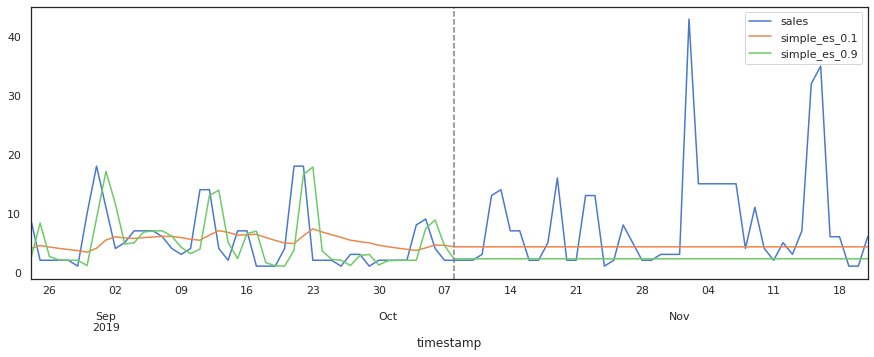

In [11]:
# dataframe de retorno
result_df = df[['sales', 'timestamp']].iloc[-forecast_horizon-45:]

def simple_exp_smoothing(data, alpha, forecast_horizon):
    model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=False)
    pred = model.forecast(forecast_horizon)
    return pd.concat([model.fittedvalues.iloc[-45:], pred])

# exponential smoothing simples com alpha = 0.1
result_df['simple_es_0.1'] = simple_exp_smoothing(train['sales'], 0.1, forecast_horizon)

# exponential smoothing simples com alpha = 0.9
result_df['simple_es_0.9'] = simple_exp_smoothing(train['sales'], 0.9, forecast_horizon)

# plot
fig, ax = plt.subplots(figsize=(15,5))
result_df.plot(x='timestamp', ax=ax)
ax.axvline(split_date, color='gray', linestyle='--')

plt.show()

Para medir o erro a métrica utilizada é a raiz quadrada da média da diferença do previsto e do real, ao quadrado. Essa métrica é chamada de *Root mean squared error* (RMSE). No RMSE, o valor do erro representa um valor próximo a unidade de produtos vendidos [[2](#rmse)].

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$$

In [12]:
def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))

print(rmse(result_df[-forecast_horizon:]['sales'], result_df[-forecast_horizon:]['simple_es_0.1']))
print(rmse(result_df[-forecast_horizon:]['sales'], result_df[-forecast_horizon:]['simple_es_0.9']))

9.926249247510876
10.916031655415553


No Exponential Smoothing simple com $\alpha$ de 0.1, o erro foi de aproximadamente 9,92, o que pode ser interpretado como um erro nas previsões do modelo por cerca de 9,92 unidades diárias em relação a realidade. Para efeito de comparação podemos comparar esse valor com a média de produtos vendida no período, que é de aproximadamente 13,88. Com $\alpha$ de 0.9, o valor ficou em aproximadamente 10,91.

***

## 4. Exponential Smoothing duplo

Em 1957 Charles C. Holt extendeu o método Brown para considerar séries temporais que possuem tendências. Esse método introduz um segundo parametro de suavização chamado de $\beta$ que manipula a inclinação da tendência da série temporal. A definição matemática do método é dividida em 4 funções, o cálculo base que é o Exponential Smoothing simples, uma função que cálcula a tendências, a terceira função é para ajustar o modelo e finalmente a última função é responsável por realizar a previsão do futuro.

$$\begin{align}
\ell_t = \alpha Y_{t-1} + (1 - \alpha) \ell_{t-1}\tag*{(Nível) }\\
b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}\tag*{(Tendência) } \\
\hat{y}_t + h = \ell_t + hb_t\tag*{(Previsão para $h$ períodos) }
\end{align}$$

Onde:
 - $\beta$: Coeficiente de suavização para a inclinação da tendência, onde $0 \le \beta \le 1$. Quanto mais próximo de 0, menor será a suavização da tendência;
 - $b$: Vetor $b_1, b_2, \dots, b_t$ com os coeficiêntes de tendência;
 - $h$: Quantidade de períodos no futuro que se deseja realizar a previsão.

Na biblioteca statsmodels, a classe `ExponentialSmoothing` é utilizada para aplicar o Exponential Smoothing. Nesse exemplo $\alpha$ está utilizando um valor fixo de 0.5 e 3 valores para $\beta$ são testados: 0.1, 0.5 e 0.9:

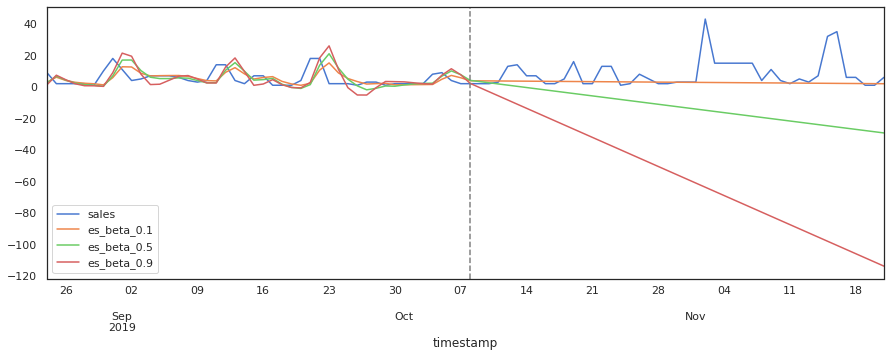

In [13]:
# dataframe de retorno
result_df = df[['sales', 'timestamp']].iloc[-forecast_horizon-45:]

def exp_smoothing(data, alpha, beta, forecast_horizon):
    model = ExponentialSmoothing(data, trend='add').fit(smoothing_level=alpha, smoothing_slope=beta)
    pred = model.forecast(forecast_horizon)
    return pd.concat([model.fittedvalues.iloc[-45:], pred])

# exponential smoothing simples com alpha = 0.1
result_df['es_beta_0.1'] = exp_smoothing(train['sales'], 0.5, 0.1, forecast_horizon)

# exponential smoothing simples com beta = 0.5
result_df['es_beta_0.5'] = exp_smoothing(train['sales'], 0.5, 0.5, forecast_horizon)

# exponential smoothing simples com beta = 0.5
result_df['es_beta_0.9'] = exp_smoothing(train['sales'], 0.5, 0.9, forecast_horizon)

# plot
fig, ax = plt.subplots(figsize=(15,5))
result_df.plot(x='timestamp', ax=ax)
ax.axvline(split_date, color='gray', linestyle='--')

plt.show()

In [14]:
print(rmse(result_df[-forecast_horizon:]['sales'], result_df[-forecast_horizon:]['es_beta_0.1']))
print(rmse(result_df[-forecast_horizon:]['sales'], result_df[-forecast_horizon:]['es_beta_0.5']))
print(rmse(result_df[-forecast_horizon:]['sales'], result_df[-forecast_horizon:]['es_beta_0.9']))

10.67136825145278
25.536581546521816
74.09240508415171


As últimas observações da série temporal possuem um tendência negativa, então o fator de inclinação $\beta$ seguiu o comportamento da série. Visivelmente $\beta$ com 0.9 teve um resultado ruim, enquanto que o melhor resultado foi $\beta$ com 0.1.

***

## 5. Exponential Smoothing triplo (Holt-Winters)

Para realizar as previsões, os métodos anteriores simplesmente extendem uma linha em relação as observações mais recentes. Para considerar a flutuação dos efeitos sazonais, A terceira versão do Exponential Smoothing foi proposta por Peter R. Winters. O método também é conhecido como método de Holt-Winters. O procedimento é uma extensão do Exponential Smoothing duplo, porém considera com um novo componente, que é a sazonalidade. Sazonalidade é um padrão que se repete em um intervalo fixo de tempo. Nessa variação do Exponential Smoothing, dois novos parâmetros são introduzidos: $\gamma$ é o valor da suavização da sazonalidade e $m$ que é a frequência da sazonalidade.

O método de Holt-Winters possui duas variações, a aditiva e a multiplicativa. O método aditivo deve ser utilizado quando as variações sazonais são constantes através da série temporal. Quando as variações sazonais sofrem alterações proporcionais as mudanças do tempo, o modelo multiplicativo deve ser usado.

O modelo aditivo do método de Holt-Winters é definido da seguinte forma:

$$\begin{align}
\ell_t = \alpha Y_{t-1} + (1 - \alpha) \ell_{t-1}\tag*{(Nível) }\\
b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}\tag*{(Tendência) } \\
s_t = \gamma(Y_t - \ell_{t-1} - b_{t-1}) + (1-\gamma)s_{t-1}\tag*{(Sazonalidade) } \\
\hat{y}_{t + h|t} = \ell_t + hb_t + s_{t + h - m(k+1)}\tag*{(Previsão para $h$ períodos) }
\end{align}$$

Onde:
 - $\gamma$: Coeficiente de suavização da sazonalidade tendência, onde $0 \le \gamma \le 1$. Quanto mais próximo de 0, menor será a suavização da sazonalidade;
 - $s$: Vetor $s_1, s_2, \dots, s_t$ com os coeficiêntes de sazonalidade;
 - $m$: Frequência da sazonalidade. Por exemplo, para sazonalidades anuais $m=365.25$ e para sazonalidade mensal $m=12$;
 - $k$: Parte inteira (mod) de $(h-1)/m$.
 
No modelo multiplicativo, as funções base e de sazonalidade são diferentes. As demais permanecem iguais:

$$\begin{align}
\ell_t = \alpha \frac{Y_t}{s_t-m} + (1-\alpha)(\ell_{t-1} + b_{t-1})\tag*{(Nível) }\\
s_t = \gamma \frac{y_t}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}\tag*{(Sazonalidade) } \\
\end{align}$$

Para utilizar o método de Holt-Winters no statmodels, basta informar os novos parâmetros da sazonalidade no objeto `ExponentialSmoothing`. Nesse exemplo, utilizamos a sazonalidade aditiva alterando os valores de $\gamma$.

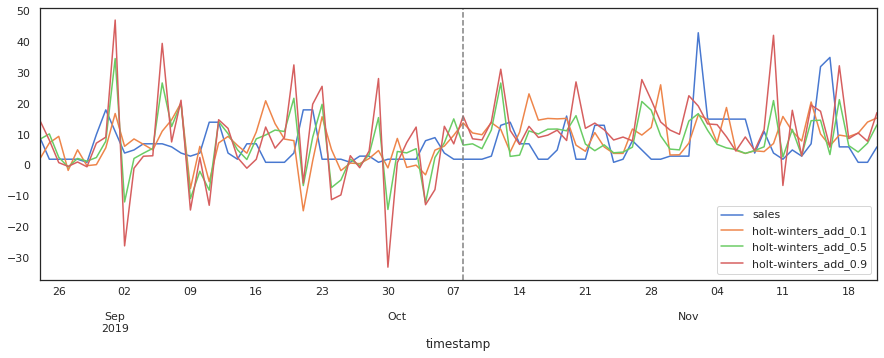

In [15]:
# dataframe de retorno
result_df = df[['sales', 'timestamp']].iloc[-forecast_horizon-45:]

def exp_smoothing3(data, alpha, beta, gamma, m, forecast_horizon):
    model = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=m)
    model = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    pred = model.forecast(forecast_horizon)
    return pd.concat([model.fittedvalues.iloc[-45:], pred])

result_df['holt-winters_add_0.1'] = exp_smoothing3(train['sales'], 
                                                   alpha=0.5, 
                                                   beta=0, 
                                                   gamma=0.1, 
                                                   m=365,
                                                   forecast_horizon=forecast_horizon)

result_df['holt-winters_add_0.5'] = exp_smoothing3(train['sales'], 
                                                   alpha=0.5, 
                                                   beta=0, 
                                                   gamma=0.5, 
                                                   m=365,
                                                   forecast_horizon=forecast_horizon)

result_df['holt-winters_add_0.9'] = exp_smoothing3(train['sales'], 
                                                   alpha=0.5, 
                                                   beta=0, 
                                                   gamma=0.9, 
                                                   m=365,
                                                   forecast_horizon=forecast_horizon)

# plot
fig, ax = plt.subplots(figsize=(15,5))
result_df.plot(x='timestamp', ax=ax)
ax.axvline(split_date, color='gray', linestyle='--')

plt.show()

In [16]:
print(rmse(result_df[-forecast_horizon:]['sales'], result_df[-forecast_horizon:]['holt-winters_add_0.1']))
print(rmse(result_df[-forecast_horizon:]['sales'], result_df[-forecast_horizon:]['holt-winters_add_0.5']))
print(rmse(result_df[-forecast_horizon:]['sales'], result_df[-forecast_horizon:]['holt-winters_add_0.9']))

10.755806939197269
10.401199391382518
13.3119321041177


Como pode-se observar, o melhor resultado foi com a utilização da suavização da sazonalidade com valor de 0.5, porém a diferença não foi muito grande. Uma alternativa para melhorar essas previsisões, além dos parâmetros, é alterar o período da sazonalidade de 365 para 7, uma vez que é possível perceber que a série temporal, além de possuir um sazonalidade anual, também possui uma sazonalidade semanal.

## 6. Conclusão

Esse trabalho demonstrou o funcionamento do método Exponential Smoothing. Um dos aspectos abordados e demonstrados foram as três variações do método. Com isso foi possível observer que Exponential Smoothing trabalha sobre os principais componentes que formam uma série temporal.

O Exponential Smoothing é um método estatístico que realiza boas previsões de forma rápida. Contudo, apesar dos resultados, ainda há bastante espaço para melhoras. Pode-se por exemplo, utilizar a transformação de log da série temporal. Outra alternativa é trabalhar com diferentes valores de $\alpha$, $\beta$ e $\gamma$ para buscar o modelo que mais se ajusta a série temporal em questão.

Nos próximos posts serão apresentados outros algoritmos para realizar previsões de séries temporais.

***

## 7. Referências

<a class="anchor" id="ref-1">[1]</a> [Forecast: Principles and Prectice - Chapter 7 Exponential smoothing](https://otexts.com/fpp2/expsmooth.html)<br>
<a class="anchor" id="rmse">[2]</a> [Statistics How To - RMSE: Root Mean Square Error](https://www.statisticshowto.datasciencecentral.com/rmse/)